In [1]:
from __future__ import annotations
from tqdm.auto import tqdm

import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

import pyro
import pyro.primitives
import pyro.distributions as dist

from pyro import poutine
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import ClippedAdam


sys.path.append("../")
sys.path.append("../../")

import vectorized_loop as vec
from vectorized_loop.ops import Index
from util import time_it

device = "cpu"

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

torch.Size([10, 200]) torch.Size([10, 200]) torch.Size([10, 200])


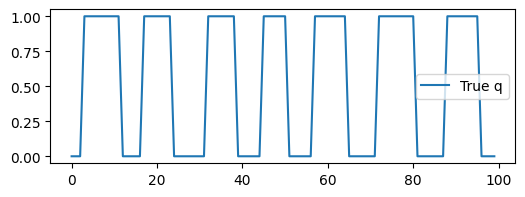

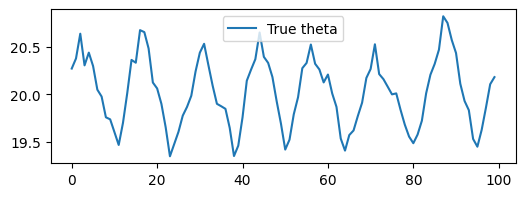

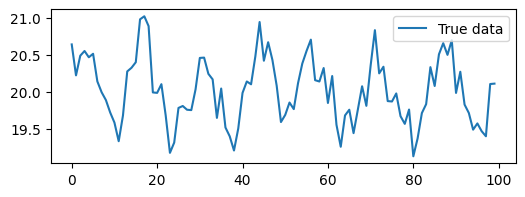

In [ ]:
@vec.vectorize
def model(s: vec.State):
    B = 10
    N = 200
    theta_a = 32.0
    theta_lower = 19.5
    theta_upper = 20.5
    invCR = 1/15
    RP_rate = 21.0
    sigma_0 = 0.2
    sigma_1 = 0.22
    sqrt_time_step = 0.5

    for s.b in vec.range("batch", B, vectorized=True, device=device):    
        s.q = 0
        s.theta = 20
        for s.i in tqdm(vec.range("time", N, vectorized=False, device=device), total=N):
            with vec.branch(s.theta <= theta_lower):
                s.q_noise = pyro.sample("q_noise", dist.Normal(0.0, 1e-3))
            with vec.branch(s.theta >= theta_upper):
                s.q_noise = pyro.sample("q_noise", dist.Normal(1.0, 1e-3)) 
            with vec.branch((theta_lower < s.theta) & (s.theta < theta_upper)):
                s.q_noise = pyro.sample("q_noise", dist.Normal(s.q, 1e-3))

            s.q = torch.as_tensor(s.q_noise > 0.5, dtype=torch.float)
            s.b = invCR * (theta_a - s.theta - s.q * RP_rate)
            s.sigma = torch.where(s.q_noise > 0.5, sigma_1, sigma_0)
            s.theta = pyro.sample("theta", dist.Normal(s.theta + s.b * sqrt_time_step ** 2, s.sigma * sqrt_time_step))
            pyro.sample("obs", dist.Normal(s.theta, 2e-1))


tr_model = vec.trace(model).get_trace()
q_noise = tr_model.nodes["q_noise"]["value"].T
theta = tr_model.nodes["theta"]["value"].T
data = tr_model.nodes["obs"]["value"].T
q = torch.as_tensor(q_noise > 0.5, dtype=torch.float)

print(q.shape, theta.shape, data.shape)
np.savetxt("q.txt", q.detach().cpu().numpy())
np.savetxt("theta.txt", theta.detach().cpu().numpy())
np.savetxt("data.txt", data.detach().cpu().numpy())

b = np.random.randint(0, len(q))

plt.figure(figsize=(6, 2))
plt.plot(q.detach().cpu().numpy()[b, :100], label="True q")
plt.legend()
plt.show()

plt.figure(figsize=(6, 2))
plt.plot(theta.detach().cpu().numpy()[b, :100], label="True theta")
plt.legend()
plt.show()

plt.figure(figsize=(6, 2))
plt.plot(data.detach().cpu().numpy()[b, :100], label="True data")
plt.legend()
plt.show()